In [1]:
# from datetime import datetime
# import json
import gc

import pandas as pd
import numpy as np

In [2]:
# data_path = 'turo_rental_car_pricing.json'
# data_path = 'scraped/dataset_turo-scraper_Central_Valley.json'
data_path = 'scraped/dataset_turo-scraper_BayArea.json'
df = pd.read_json(data_path)
print(df.shape)

(81, 36)


In [3]:
# df['averageDailyPrice'] = df['rate'].apply(lambda x: x['averageDailyPrice'])
# df['averageDailyPrice'].describe()

In [4]:
veh_df    = pd.json_normalize(df['vehicle'])
locations = pd.json_normalize(df['location'])
rates     = pd.json_normalize(df['rate'])
owner     = pd.json_normalize(df['owner'])
veh_df.shape, locations.shape, rates.shape, owner.shape

((81, 33), (81, 12), (81, 28), (81, 17))

In [5]:
big = pd.concat([df, veh_df, locations, rates, owner], axis=1)\
    .drop(['rate', 'vehicle', 'location', 'owner'], axis=1)
big.shape

(81, 122)

In [6]:
del veh_df, locations, rates, owner

In [7]:
gc.collect()

0

In [8]:
big = pd.read_csv('merged_prices_Central_Valley.csv')

count                               33
mean     2023-05-18 17:34:18.303030272
min                2021-07-24 07:35:14
25%                2022-11-20 19:22:23
50%                2023-09-10 02:02:57
75%                2023-12-19 02:10:37
max                2024-03-07 03:57:34
Name: listingCreatedTime, dtype: object

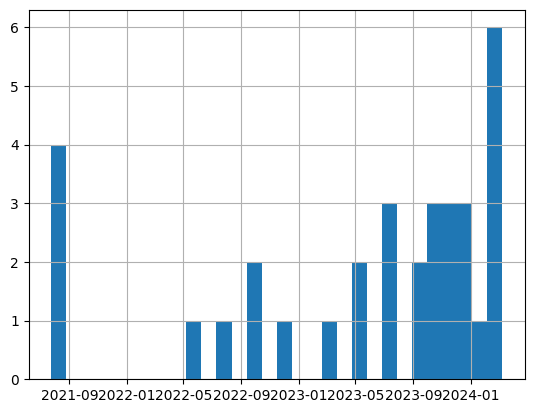

In [9]:
big['listingCreatedTime'] = pd.to_datetime(big['listingCreatedTime'], unit='ms')
big['listingCreatedTime'].hist(bins=30)
big['listingCreatedTime'].describe()

In [10]:
today = big['listingCreatedTime'].max()
today

Timestamp('2024-03-07 03:57:34')

<Axes: >

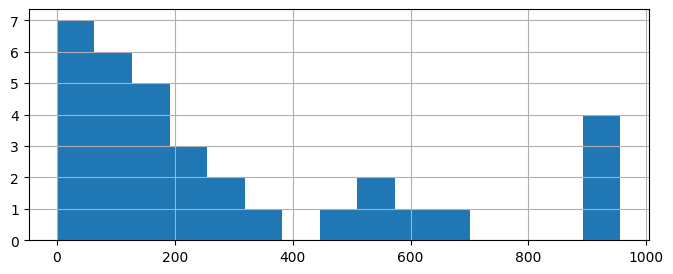

In [11]:
big['listingDays'] = (today - big['listingCreatedTime']).dt.days
big['listingDays'].hist(bins=15, figsize=(8, 3))

In [12]:
big['listingDays'].describe()

count     33.000000
mean     293.121212
std      301.813556
min        0.000000
25%       79.000000
50%      179.000000
75%      472.000000
max      956.000000
Name: listingDays, dtype: float64

<Axes: >

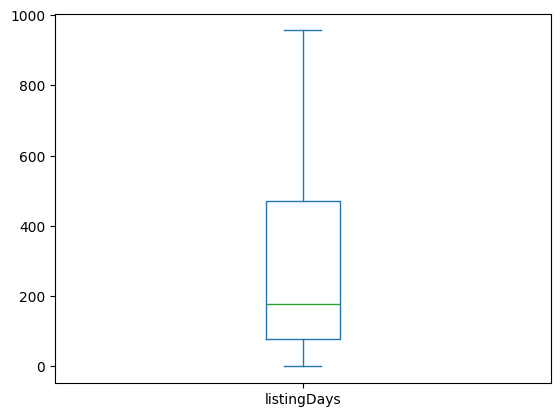

In [13]:
big['listingDays'].plot.box()

In [14]:
big.rename({'numberOfRentals':'renterTripsTaken',
            'numberOfReviews':'reviewCount'}, axis=1, inplace=True)

In [15]:
big.renterTripsTaken.sum(), big.reviewCount.sum()

(633, 503)

In [16]:
cleaned = big[\
    (big['listingDays'] > 30) &\
    # (big['listingCreatedTime'] < '2024-02-10') &\
    (big['listingCreatedTime'].dt.year > 2021) &\
    (big['country'] == 'US') &\
    (big['state'] == 'CA') &\
    (big['renterTripsTaken'] > 0)
]
cleaned.shape

(22, 126)

In [17]:
# cleaned[['make', 'model', 'year', 'city', 'averageDailyPrice', 'listingCreatedTime']]

## Average occupancy rate in days

C:\Users\26823\AppData\Local\Temp\ipykernel_22552\689015806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['occupancyDays'] = avg_days_per_trip * cleaned['renterTripsTaken']


<Axes: >

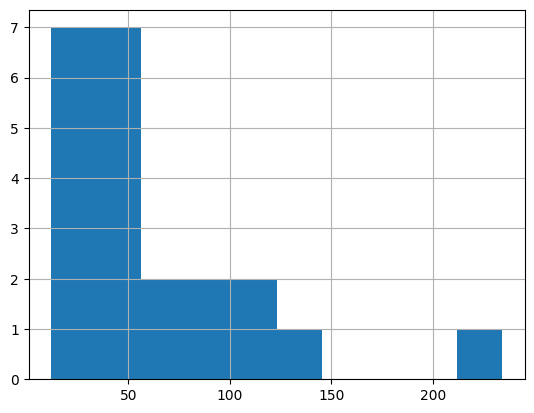

In [18]:
avg_days_per_trip = 3
cleaned['occupancyDays'] = avg_days_per_trip * cleaned['renterTripsTaken']
cleaned['occupancyDays'].hist()

C:\Users\26823\AppData\Local\Temp\ipykernel_22552\297223462.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned.loc[:, 'occupancyRate'] = cleaned['occupancyDays'] / cleaned['listingDays']


<Axes: >

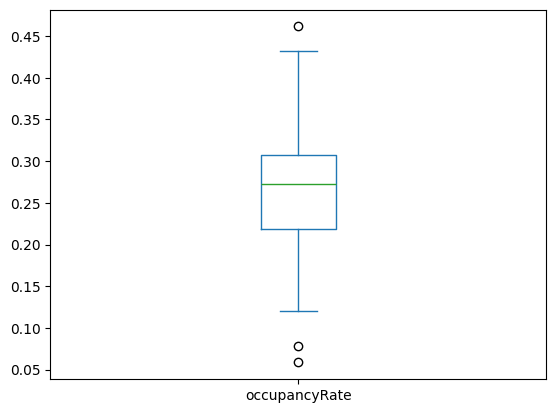

In [19]:
cleaned.loc[:, 'occupancyRate'] = cleaned['occupancyDays'] / cleaned['listingDays']
# df[df['occupancyRate'] < np.inf]['occupancyRate'].plot.box()
cleaned.loc[:, 'occupancyRate'] = cleaned['occupancyRate'].replace(np.inf, 0)
cleaned['occupancyRate'].plot.box()

<Axes: >

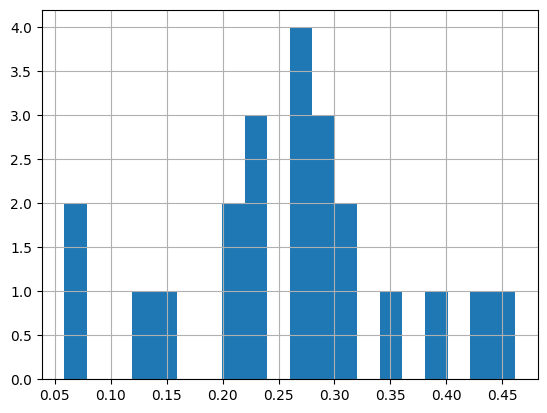

In [20]:
cleaned['occupancyRate'].hist(bins=20)

## Monthly revenue for each listing

count      22.000000
mean      488.213898
std       191.297512
min       259.423009
25%       340.722727
50%       444.915378
75%       581.482855
max      1032.446429
Name: totalMonthlyRevenue, dtype: float64


C:\Users\26823\AppData\Local\Temp\ipykernel_22552\3455108191.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['totalRevenue'] = cleaned['occupancyDays'] * cleaned['averageDailyPrice']
C:\Users\26823\AppData\Local\Temp\ipykernel_22552\3455108191.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned['totalMonthlyRevenue'] = 30 * cleaned['totalRevenue'] / cleaned['listingDays']


<Axes: >

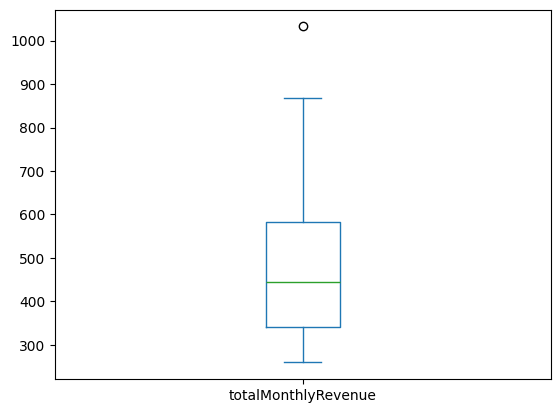

In [21]:
cleaned['totalRevenue'] = cleaned['occupancyDays'] * cleaned['averageDailyPrice']
cleaned['totalMonthlyRevenue'] = 30 * cleaned['totalRevenue'] / cleaned['listingDays']
print(cleaned['totalMonthlyRevenue'].describe())
cleaned['totalMonthlyRevenue'].plot.box()

## Occupancy Rate for each vehicle (model, make)

In [35]:
cleaned['occupancyRate'].max() * 30

13.846153846153847

In [28]:
colname = 'occupancyRate'
cleaned[['make', 'model', colname]]\
    .groupby(['make', 'model'], as_index=False).mean()\
    .sort_values(colname, ascending=False)\
    .head(30)

,make,model,occupancyRate
9,Hyundai,Elantra,0.461538
5,Chevrolet,Malibu,0.431818
1,Acura,RDX,0.391960
10,Hyundai,Kona,0.317406
8,Honda,Odyssey,0.293130
16,Toyota,Corolla,0.287671
17,Toyota,Sienna,0.285714
0,Acura,MDX,0.281250
3,Chevrolet,Equinox,0.274854
12,Kia,Soul,0.272727


In [59]:
# query_make = 'Acura'
# grouped_occrate[grouped_occrate['make'] == query_make].sort_values('averageDailyPrice', ascending=False)

## Daily rate for each vehicle (model, make, year)

In [60]:
colname = 'averageDailyPrice'
cleaned[['make', 'model', colname]]\
    .groupby(['make', 'model'], as_index=False).mean()\
    .sort_values(colname, ascending=False)

,make,model,averageDailyPrice
13,Land Rover,Range Rover,170.05
14,Tesla,Model X,170.05
7,GMC,Sierra 1500,151.05
4,Chevrolet,Express,109.25
15,Tesla,Model Y,77.40
17,Toyota,Sienna,75.00
6,Ford,F-150,74.80
8,Honda,Odyssey,66.34
0,Acura,MDX,57.00
2,BMW,X2,55.29


## Total Monthly Revenue for each vehicle (model, make)

In [61]:
colname = 'totalMonthlyRevenue'
cleaned[['make', 'model', colname]]\
    .groupby(['make', 'model'], as_index=False).mean()\
    .sort_values(colname, ascending=False)\
    .head(20)

,make,model,totalMonthlyRevenue
14,Tesla,Model X,1032.446429
9,Hyundai,Elantra,648.000000
17,Toyota,Sienna,642.857143
5,Chevrolet,Malibu,615.340909
8,Honda,Odyssey,580.451545
15,Tesla,Model Y,516.000000
6,Ford,F-150,506.328474
4,Chevrolet,Express,487.561983
0,Acura,MDX,480.937500
2,BMW,X2,446.573077


## Count of listings for each vehicle (model, make)

In [62]:
cleaned\
    .groupby(['make', 'model'], as_index=False).count()\
    [['make', 'model', 'count']]\
    .sort_values('count', ascending=False)\
    .head(5)
    # .rename({count_col:'count'}, axis=1)\

C:\Users\26823\AppData\Local\Temp\ipykernel_6228\2047389735.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .groupby(['make', 'model'], as_index=False).count()\
C:\Users\26823\AppData\Local\Temp\ipykernel_6228\2047389735.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  .groupby(['make', 'model'], as_index=False).count()\


,make,model,count
6,Ford,F-150,3
8,Honda,Odyssey,2
0,Acura,MDX,1
11,Hyundai,Sonata,1
17,Toyota,Sienna,1


## All in one place

In [63]:
colnames = ['occupancyRate', 'averageDailyPrice', 'totalMonthlyRevenue', 'price', count_col]
agg_dict = {col:'mean' for col in colnames}
agg_dict[count_col] = 'count'
result = cleaned[['make', 'model', 'year'] + colnames]\
    .groupby(['make', 'model', 'year'], as_index=False).agg(agg_dict)\
    .rename({count_col:'cnt'}, axis=1)\
    .sort_values('totalMonthlyRevenue', ascending=False)\
    .query('cnt > 0 and occupancyRate > 0.1')
result.head(25)

,make,model,year,occupancyRate,averageDailyPrice,totalMonthlyRevenue,price,cnt
16,Tesla,Model X,2019,0.202381,170.05,1032.446429,94191.290323,1
11,Hyundai,Elantra,2019,0.461538,46.80,648.000000,15174.403349,1
19,Toyota,Sienna,2017,0.285714,75.00,642.857143,25555.251739,1
5,Chevrolet,Malibu,2021,0.431818,47.50,615.340909,26398.172500,1
7,Ford,F-150,2021,0.231267,87.30,596.738522,52017.488372,2
9,Honda,Odyssey,2014,0.314448,61.75,582.514164,16307.568106,1
10,Honda,Odyssey,2018,0.271812,70.93,578.388926,30199.402500,1
17,Tesla,Model Y,2020,0.222222,77.40,516.000000,64293.400000,1
4,Chevrolet,Express,2019,0.148760,109.25,487.561983,25959.970949,1
0,Acura,MDX,2016,0.281250,57.00,480.937500,25269.731034,1


## Vehicle types analysis

In [64]:
cleaned['type'].value_counts(normalize=True)

type
SUV        0.409091
CAR        0.227273
TRUCK      0.181818
MINIVAN    0.136364
VAN        0.045455
Name: proportion, dtype: float64

In [65]:
colnames = ['occupancyRate', 'averageDailyPrice', 'totalMonthlyRevenue', count_col]
agg_dict = {col:'mean' for col in colnames}
agg_dict[count_col] = 'count'
cleaned[['type'] + colnames]\
    .groupby(['type'], as_index=False).agg(agg_dict)\
    .rename({count_col:'cnt'}, axis=1)\
    .sort_values('totalMonthlyRevenue', ascending=False)\
    .query('cnt > 0 and occupancyRate > 0.1')\
    .head(25)

,type,occupancyRate,averageDailyPrice,totalMonthlyRevenue,cnt
1,MINIVAN,0.290658,69.226667,601.253411,3
4,VAN,0.148760,109.250000,487.561983,1
2,SUV,0.249272,76.945556,472.097749,9
3,TRUCK,0.189688,93.862500,468.496932,4
0,CAR,0.338119,45.524000,465.303213,5


### Make analysis

In [66]:
colnames = ['occupancyRate', 'averageDailyPrice', 'totalMonthlyRevenue', count_col]
agg_dict = {col:'mean' for col in colnames}
agg_dict[count_col] = 'count'
cleaned[['make'] + colnames]\
    .groupby(['make'], as_index=False).agg(agg_dict)\
    .rename({count_col:'cnt'}, axis=1)\
    .sort_values('totalMonthlyRevenue', ascending=False)\
    .query('cnt > 1 and occupancyRate > 0.25')\
    .head(25)

,make,occupancyRate,averageDailyPrice,totalMonthlyRevenue,cnt
5,Honda,0.293130,66.340000,580.451545,2
10,Toyota,0.286693,60.300000,518.195695,2
2,Chevrolet,0.285144,65.866667,479.912075,3
6,Hyundai,0.338596,46.000000,469.502560,3
0,Acura,0.336605,47.000000,458.006438,2


### Prices and TCO

Грубая оценка без учёта maintenace cost

In [69]:
result.dropna(subset='price', inplace=True)
result['annual_revenue'] = result['totalMonthlyRevenue'] * 12
result['years_to_payback'] = result['price'] / result['annual_revenue']
result['ROI'] = result['annual_revenue'] / result['price']
result.sort_values(['years_to_payback']).head(25)

,make,model,year,occupancyRate,averageDailyPrice,totalMonthlyRevenue,price,cnt,annual_revenue,years_to_payback,ROI,rate/price
11,Hyundai,Elantra,2019,0.461538,46.80,648.000000,15174.403349,1,7776.000000,1.951441,0.512442,0.003084
9,Honda,Odyssey,2014,0.314448,61.75,582.514164,16307.568106,1,6990.169972,2.332929,0.428646,0.003787
14,Kia,Soul,2016,0.272727,43.07,352.390909,12184.689370,1,4228.690909,2.881433,0.347050,0.003535
1,Acura,RDX,2014,0.391960,37.00,435.075377,16006.710983,1,5220.904523,3.065888,0.326170,0.002312
20,Volkswagen,Tiguan,2012,0.225664,38.32,259.423009,9698.099010,1,3113.076106,3.115278,0.320999,0.003951
19,Toyota,Sienna,2017,0.285714,75.00,642.857143,25555.251739,1,7714.285714,3.312718,0.301867,0.002935
5,Chevrolet,Malibu,2021,0.431818,47.50,615.340909,26398.172500,1,7384.090909,3.575006,0.279720,0.001799
18,Toyota,Corolla,2020,0.287671,45.60,393.534247,18949.888534,1,4722.410959,4.012757,0.249205,0.002406
10,Honda,Odyssey,2018,0.271812,70.93,578.388926,30199.402500,1,6940.667114,4.351081,0.229828,0.002349
0,Acura,MDX,2016,0.281250,57.00,480.937500,25269.731034,1,5771.250000,4.378554,0.228386,0.002256


In [71]:
result['rate/price'] = result['averageDailyPrice'] / result['price']
result.sort_values(['rate/price'], ascending=False)

,make,model,year,occupancyRate,averageDailyPrice,totalMonthlyRevenue,price,cnt,annual_revenue,years_to_payback,ROI,rate/price
4,Chevrolet,Express,2019,0.148760,109.25,487.561983,25959.970949,1,5850.743802,4.437038,0.225376,0.004208
20,Volkswagen,Tiguan,2012,0.225664,38.32,259.423009,9698.099010,1,3113.076106,3.115278,0.320999,0.003951
9,Honda,Odyssey,2014,0.314448,61.75,582.514164,16307.568106,1,6990.169972,2.332929,0.428646,0.003787
14,Kia,Soul,2016,0.272727,43.07,352.390909,12184.689370,1,4228.690909,2.881433,0.347050,0.003535
11,Hyundai,Elantra,2019,0.461538,46.80,648.000000,15174.403349,1,7776.000000,1.951441,0.512442,0.003084
19,Toyota,Sienna,2017,0.285714,75.00,642.857143,25555.251739,1,7714.285714,3.312718,0.301867,0.002935
18,Toyota,Corolla,2020,0.287671,45.60,393.534247,18949.888534,1,4722.410959,4.012757,0.249205,0.002406
10,Honda,Odyssey,2018,0.271812,70.93,578.388926,30199.402500,1,6940.667114,4.351081,0.229828,0.002349
1,Acura,RDX,2014,0.391960,37.00,435.075377,16006.710983,1,5220.904523,3.065888,0.326170,0.002312
0,Acura,MDX,2016,0.281250,57.00,480.937500,25269.731034,1,5771.250000,4.378554,0.228386,0.002256
